# Set Environment

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from collections import Counter
from tqdm.notebook import tqdm
import cv2
import gc
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

TensorFlow version: 2.12.0


# Reproducibility

In [2]:
def set_seed(seed=19021):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

# Metadata Frames from Excel

**Image Associated Data**

In [3]:
image_df = pd.read_excel('/kaggle/input/bme-400-g03/IARCImageBankColpo/Cases - Images.xlsx')
image_df.head(20)

,Case Number,File,Sort,Type
0,1,AAAW1.jpg,1,After normal saline
1,1,AAAW3.jpg,2,After acetic acid
2,1,AAAW2.jpg,3,After acetic acid with green filter
3,1,AAAW4.jpg,4,After Lugol’s iodine
4,2,AADE0.jpg,1,After acetic acid
5,2,AADE1.jpg,2,After acetic acid
6,2,AADE3.jpg,3,After acetic acid
7,2,AADE4.jpg,4,After Lugol’s iodine
8,3,AADG0.jpg,1,Speculum examination
9,3,AADG1.jpg,2,After normal saline with green filter


**Case Associated Data**

In [4]:
case_df = pd.read_excel('/kaggle/input/bme-400-g03/IARCImageBankColpo/Cases Meta data.xlsx')
case_df.columns = case_df.iloc[0]
case_df = case_df[1:]
case_df.reset_index(drop=True, inplace=True)
case_df.head(20)

,Case Number,CaseID,HPV,Adequacy,Reason,Squamocolumnar junction visibility,Transformation zone,Original squamous epithelium,Columnar epithelium,Metaplastic squamous epithelium,...,Additional miscellaneous finding,Aceto uptake,Margins,Vessels,Lesion size,Iodine uptake,SwedeFinal,\nProvisional diagnosis,Management,Histopathology
0,1,AAAW,Positive,Adequate,NaN,Completely visible,Type 1,Mature,Ectopy absent,Nabothian cysts,...,NaN,Nil or transparent,Nil or diffuse,"Fine, regular",< 5 mm,Faintly or patchy yellow,1,Type 1 transformation zone; normal,Repeat HPV test/colposcopy after 1 year,Not done
1,2,AADE,Negative,Adequate,NaN,Completely visible,Type 1,Mature,Ectopy present,Crypt (gland) openings,...,NaN,Nil or transparent,Nil or diffuse,"Fine, regular",< 5 mm,Brown,0,Type 1 transformation zone; normal,Routine screening after 5 years,Not done
2,3,AADG,Negative,Adequate,NaN,Completely visible,Type 1,Mature,Ectopy absent,Crypt (gland) openings,...,NaN,Nil or transparent,Nil or diffuse,Absent,< 5 mm,Brown,1,Type 1 transformation zone; normal,Routine screening after 5 years,Not done
3,4,AAEG,Negative,Adequate,NaN,Completely visible,Type 1,Mature,Ectopy absent,NaN,...,NaN,Nil or transparent,Nil or diffuse,"Fine, regular",< 5 mm,Brown,0,Type 1 transformation zone; normal,Routine screening after 5 years,Not done
4,5,AAER,Positive,Adequate,NaN,Completely visible,Type 2,Mature,NaN,NaN,...,NaN,Nil or transparent,Nil or diffuse,Absent,">15 mm, 3-4 quadrants, or endocervically undef...",Faintly or patchy yellow,4,Type 2 transformation zone; normal,Repeat HPV test/colposcopy after 1 year,Not done
5,6,AAFU,Negative,Adequate,NaN,Completely visible,Type 1,Mature,Ectopy absent,Crypt (gland) openings,...,NaN,Nil or transparent,Nil or diffuse,"Fine, regular",< 5 mm,Brown,0,Type 1 transformation zone; normal,Routine screening after 5 years,Not done
6,7,AAFY,Negative,Adequate,NaN,Completely visible,Type 1,Mature,Ectopy absent,Nabothian cysts and Crypt (gland) openings,...,NaN,Nil or transparent,Nil or diffuse,Absent,< 5 mm,Brown,1,Type 1 transformation zone; normal,Routine screening after 5 years,Not done
7,8,AAFZ,Negative,Adequate,NaN,Completely visible,Type 1,Mature,NaN,NaN,...,NaN,Nil or transparent,Nil or diffuse,Absent,< 5 mm,Unknown,99,Type 1 transformation zone; normal,Routine screening after 5 years,Not done
8,9,AAGB,Negative,Adequate,NaN,Completely visible,Type 1,Mature,Ectopy absent,Crypt (gland) openings,...,NaN,Nil or transparent,Nil or diffuse,"Fine, regular",< 5 mm,Brown,0,Type 1 transformation zone; normal,Routine screening after 5 years,Not done
9,10,AAGC,Negative,Adequate,NaN,Completely visible,Type 1,Mature,NaN,NaN,...,NaN,Nil or transparent,Nil or diffuse,"Fine, regular",< 5 mm,Brown,0,Type 1 transformation zone; normal,Routine screening after 5 years,Not done


# Transformation Zone Counts

Counter({'Type 1': 114, 'Type 3': 51, 'Type 2': 33, nan: 2})


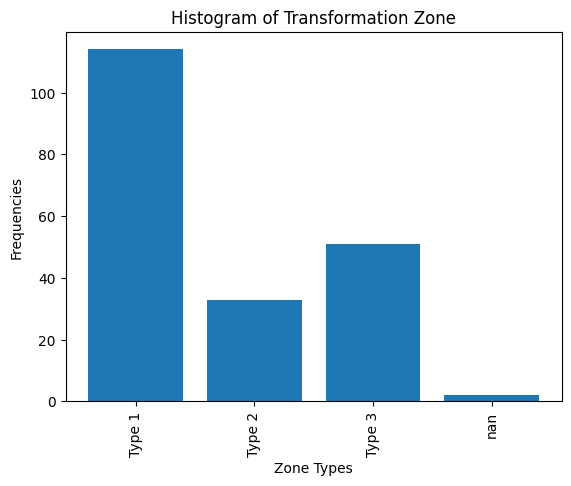

In [5]:
tz = Counter(case_df['Transformation zone'])
print(tz)

values = [str(value) for value in tz.keys()]
frequencies = list(tz.values())
plt.bar(values, frequencies)
plt.xticks(rotation=90)
plt.xlabel('Zone Types')
plt.ylabel('Frequencies')
plt.title('Histogram of Transformation Zone')
plt.show()

# Drop Undefined TZ Cases

In [6]:
case_df = case_df.dropna(subset=['Transformation zone'])
print(f'Cases with defined transformation zone: {case_df.shape[0]}')

Cases with defined transformation zone: 198


# Formatting Case Number

In [7]:
case_df['Case Number'] = case_df['Case Number'].apply(lambda x: f"{x:03d}")
case_df.head(20)

,Case Number,CaseID,HPV,Adequacy,Reason,Squamocolumnar junction visibility,Transformation zone,Original squamous epithelium,Columnar epithelium,Metaplastic squamous epithelium,...,Additional miscellaneous finding,Aceto uptake,Margins,Vessels,Lesion size,Iodine uptake,SwedeFinal,\nProvisional diagnosis,Management,Histopathology
0,001,AAAW,Positive,Adequate,NaN,Completely visible,Type 1,Mature,Ectopy absent,Nabothian cysts,...,NaN,Nil or transparent,Nil or diffuse,"Fine, regular",< 5 mm,Faintly or patchy yellow,1,Type 1 transformation zone; normal,Repeat HPV test/colposcopy after 1 year,Not done
1,002,AADE,Negative,Adequate,NaN,Completely visible,Type 1,Mature,Ectopy present,Crypt (gland) openings,...,NaN,Nil or transparent,Nil or diffuse,"Fine, regular",< 5 mm,Brown,0,Type 1 transformation zone; normal,Routine screening after 5 years,Not done
2,003,AADG,Negative,Adequate,NaN,Completely visible,Type 1,Mature,Ectopy absent,Crypt (gland) openings,...,NaN,Nil or transparent,Nil or diffuse,Absent,< 5 mm,Brown,1,Type 1 transformation zone; normal,Routine screening after 5 years,Not done
3,004,AAEG,Negative,Adequate,NaN,Completely visible,Type 1,Mature,Ectopy absent,NaN,...,NaN,Nil or transparent,Nil or diffuse,"Fine, regular",< 5 mm,Brown,0,Type 1 transformation zone; normal,Routine screening after 5 years,Not done
4,005,AAER,Positive,Adequate,NaN,Completely visible,Type 2,Mature,NaN,NaN,...,NaN,Nil or transparent,Nil or diffuse,Absent,">15 mm, 3-4 quadrants, or endocervically undef...",Faintly or patchy yellow,4,Type 2 transformation zone; normal,Repeat HPV test/colposcopy after 1 year,Not done
5,006,AAFU,Negative,Adequate,NaN,Completely visible,Type 1,Mature,Ectopy absent,Crypt (gland) openings,...,NaN,Nil or transparent,Nil or diffuse,"Fine, regular",< 5 mm,Brown,0,Type 1 transformation zone; normal,Routine screening after 5 years,Not done
6,007,AAFY,Negative,Adequate,NaN,Completely visible,Type 1,Mature,Ectopy absent,Nabothian cysts and Crypt (gland) openings,...,NaN,Nil or transparent,Nil or diffuse,Absent,< 5 mm,Brown,1,Type 1 transformation zone; normal,Routine screening after 5 years,Not done
7,008,AAFZ,Negative,Adequate,NaN,Completely visible,Type 1,Mature,NaN,NaN,...,NaN,Nil or transparent,Nil or diffuse,Absent,< 5 mm,Unknown,99,Type 1 transformation zone; normal,Routine screening after 5 years,Not done
8,009,AAGB,Negative,Adequate,NaN,Completely visible,Type 1,Mature,Ectopy absent,Crypt (gland) openings,...,NaN,Nil or transparent,Nil or diffuse,"Fine, regular",< 5 mm,Brown,0,Type 1 transformation zone; normal,Routine screening after 5 years,Not done
9,010,AAGC,Negative,Adequate,NaN,Completely visible,Type 1,Mature,NaN,NaN,...,NaN,Nil or transparent,Nil or diffuse,"Fine, regular",< 5 mm,Brown,0,Type 1 transformation zone; normal,Routine screening after 5 years,Not done


# Green Detection

In [8]:
def is_greenish(image_path, threshold):
    # Read the image
    img = cv2.imread(image_path)
    
    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define range of green color in HSV
    lower_green = (40, 40, 40)
    upper_green = (80, 255, 255)
    
    # Threshold the HSV image to get only greenish colors
    mask = cv2.inRange(hsv, lower_green, upper_green)
    
    # Count the number of greenish pixels
    green_pixel_count = cv2.countNonZero(mask)
    
    # Check if the percentage of greenish pixels is above the threshold
    total_pixels = img.shape[0] * img.shape[1]
    greenish_percentage = (green_pixel_count / total_pixels) * 100
    
    return greenish_percentage > threshold

# Data Pipeline for TZ Classification

In [9]:
data = []
labels = []
class_names = list(['Type 1','Type 2','Type 3'])
image_size = (256, 256)

common_path = '/kaggle/input/bme-400-g03/IARCImageBankColpo/Case '
for case_number, tz_class in tqdm(zip(case_df['Case Number'], case_df['Transformation zone']), total=len(case_df['Case Number']), desc='Processing cases'):
    path = common_path + case_number
    files = os.listdir(path)
    label = None
    for index, name in enumerate(class_names):
        if tz_class == name:
            label = index + 1
            break
    for i in files:
        bgr_image = cv2.imread(os.path.join(path, i))
        if bgr_image is not None:
            # Check if the image is green filtered
            if is_greenish(os.path.join(path, i), 30):
                continue
            else:
                image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        else:
            continue
        try:
            image = cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)
        except:
            continue
        data.append(image)
        labels.append(label)
        
# Remove garbage to free up memory
print(f'Freeing up memory!')
gc.collect()

Xi = np.array(data)
yi = np.array(labels)

# Delete the data and labels arrays to save memory
del data
del labels

print(f'Data Shape: {Xi.shape}')
print(f'Labels Shape: {yi.shape}')

Processing cases:   0%|          | 0/198 [00:00<?, ?it/s]

Corrupt JPEG data: 2567 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2567 extraneous bytes before marker 0xd9


Freeing up memory!
Data Shape: (878, 256, 256, 3)
Labels Shape: (878,)


# Show Random Samples

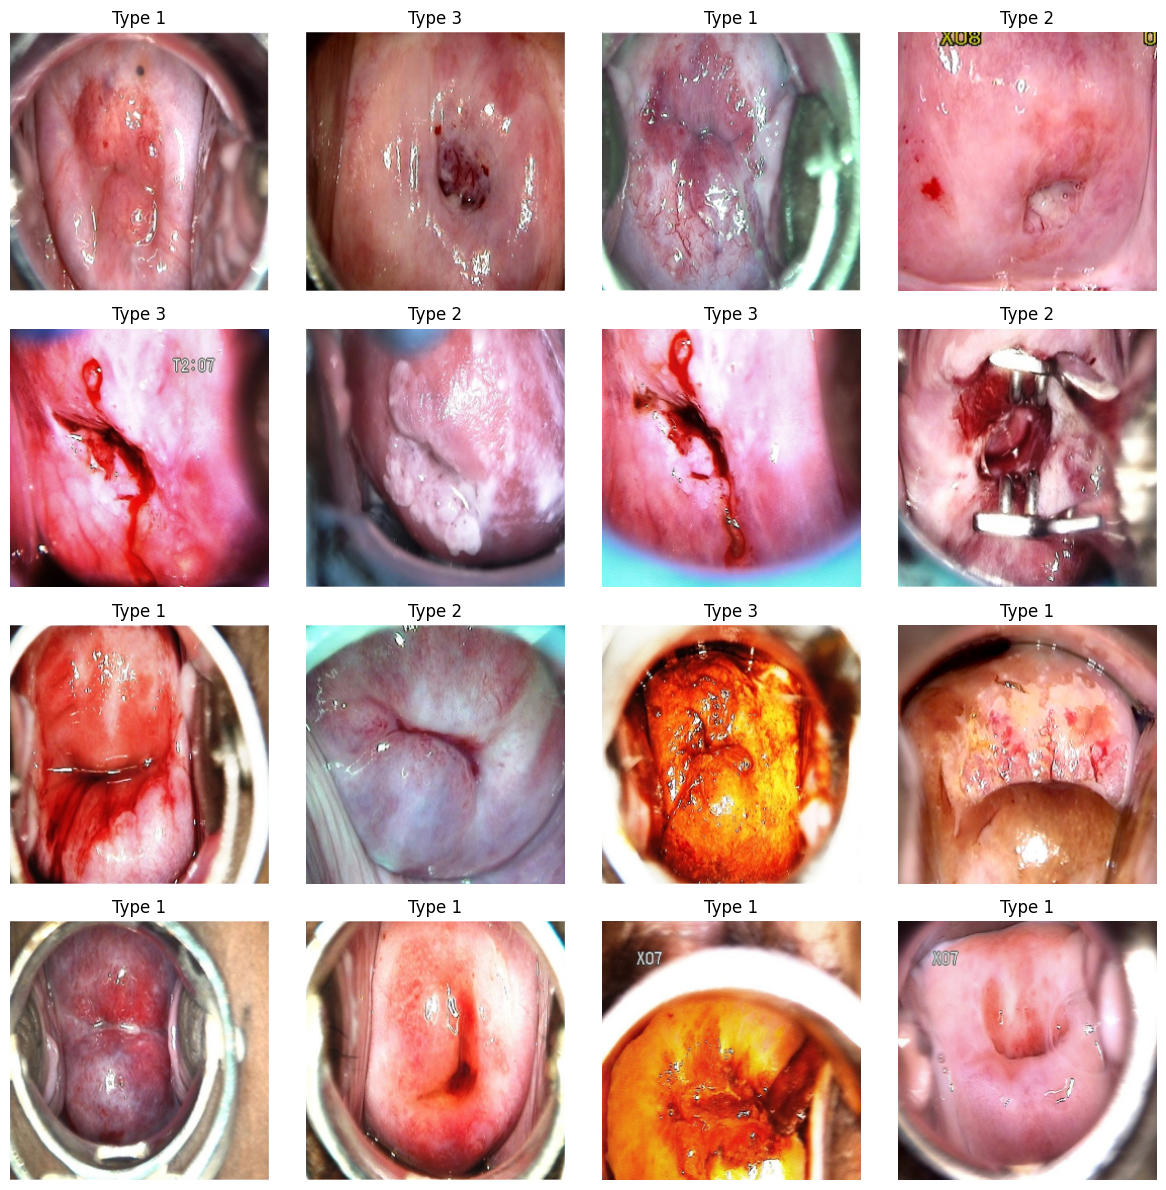

In [10]:
import random

# Function to plot images
def plot_random_samples(data, labels, class_names, sample_size=16):
    plt.figure(figsize=(12, 12))
    indices = random.sample(range(len(data)), sample_size)
    
    for i, idx in enumerate(indices):
        image = data[idx]
        label = labels[idx]
        class_name = class_names[label - 1]  # Adjusting index for class names
        plt.subplot(4, 4, i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot 16 random samples
plot_random_samples(Xi, yi, class_names)

# Save Pickle

In [11]:
import pickle

# Save data and labels using pickle
arrays = {
    'Xi': Xi,
    'yi': yi
}

print("Saving data and labels array ...")
with open('iarc_data.pkl', 'wb') as file:
    pickle.dump(arrays, file)

print("Data and labels saved successfully.")

Saving data and labels array ...
Data and labels saved successfully.
